# Introduction

We will be using Google Colab for this example on density regression using semi-parametric quantile regression (SPQR). First, go to https://colab.research.google.com/. Click File -> New notebook in Drive, and then change the runtime to R (Runtime -> Change runtime type, then pick R in the dropdown). We will not be using GPUs, so keep the CPU box checked.

# Installation
To install Keras3, run the following code. Colab already has Python and Tensorflow modules installed, so we do not need to do anything particularly complicated here.

In [1]:
remotes::install_github("rstudio/tensorflow")
install.packages(c("keras3","splines2"))
library(keras3)

png         (NA -> 0.1-8 ) [CRAN]
here        (NA -> 1.0.2 ) [CRAN]
RcppTOML    (NA -> 0.2.3 ) [CRAN]
reticulate  (NA -> 1.44.0) [CRAN]
config      (NA -> 0.3.2 ) [CRAN]
tfautograph (NA -> 0.3.2 ) [CRAN]
tfruns      (NA -> 1.5.4 ) [CRAN]


Installing 7 packages: png, here, RcppTOML, reticulate, config, tfautograph, tfruns

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpGw7c1G/remotesfa775bdf95/rstudio-tensorflow-0ffad97/DESCRIPTION’ ... OK
* preparing ‘tensorflow’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘tensorflow_2.20.0.9000.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zeallot’, ‘dotty’, ‘RcppArmadillo’




Set seed for reproducibility.

In [2]:
set_random_seed(1)

# Key functions for SPQR

The most important function in the second one, which evaluates the SPQR negative log-likelihood loss function. Since the SPQR likelihood includes M- and I-splines, the first function evaluates those. The final function is a predict function which is a wrapper around the predict function of keras. This function is used to predict PDFs, CDFs, and QFs associated with SPQR fits.

In [3]:
# Evaluate basis functions
basis <- function(y,K,knots, integral=FALSE){
  B     <- splines2::mSpline(y, knots = knots,
                   Boundary.knots=c(0,1),
                   intercept=TRUE, degree = 2,
                   integral=integral)
  return(t(B))
}

# Negative log-likelihood for SPQR
nloglik_loss_SPQR  = function (y_true, y_pred){
  numbasis <- op_shape(y_true)[[2]]
  # print(numbasis)
  probs <- y_pred[,1:numbasis]
  sumprod <- op_sum(y_true*probs,axis=2)
  spqr_loss <- -op_sum(op_log(sumprod))
  return(spqr_loss)
}

# Predict function used on fitted SPQR models
predict.SPQR <- function(model,X,Y=NULL,nY=101,tau=0.5,type='QF'){
  pred        <- as.matrix(model(X))
  n <- nrow(pred)
  ntau = length(tau)
  n.knots <- ncol(pred)
  if(is.null(Y) | type=='QF')
    Y <- seq(0,1,length.out = nY)
  B <- (basis(Y , n.knots,knots, integral = (type!='PDF')))
  if(ncol(B)!=n)
    df1  <- pred%*%B
  if(ncol(B)==n)
    df1  <- colSums(B*t(pred))
  if(type!='QF'){
    return(df1)
  }
  if(type=='QF'){
    qf1 = matrix(NA,n,ntau)
    for(i in 1:n)
      qf1[i,] <- stats::approx(df1[i,], Y, xout=tau, ties = list("ordered", min))$y
    return(qf1)
  }
}

**SPQR parameters**: Other than the neural network hyperparameters, the number of basis function knots is the only thing that needs to be set. Values between 10-25 work well in practice.

In [4]:
n.knots <- 20
knots = seq(1/(n.knots-2), 1-1/(n.knots-2), length=n.knots-3)

# Data import and pre-processing

This is temperature and precipitation data at a single grid point in the US, based on the nClimGrid dataset. It is part of the data used by [Majumder et al (2024)](https://arxiv.org/abs/2411.18799) for bias correcting climate model data. I've subsetted the `tmax` (maximum temperature) and `pr` (precipitation) data for the month of July betwen 1951-2014.

In [5]:
file_url <- "https://github.com/reetamm/AI4stats/blob/main/weather.RDS?raw=true"
weather <- readRDS(url(file_url))
weather <- weather[weather$month==7 & weather$loc==1,]
head(weather)

,time,lat,lon,tmax,pr,month,loc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4526,1951-07-01 00:00:00,34.39791,248.75,306.8169,0,7,1
4551,1951-07-02 00:00:00,34.39791,248.75,306.3290,0,7,1
4576,1951-07-03 00:00:00,34.39791,248.75,306.1381,0,7,1
4601,1951-07-04 00:00:00,34.39791,248.75,306.2251,0,7,1
4626,1951-07-05 00:00:00,34.39791,248.75,305.7951,0,7,1
4651,1951-07-06 00:00:00,34.39791,248.75,307.0995,0,7,1


Instead of modeling the raw precip, we use a log-transform. The data is split in an 80/20 ratio as training and testing.

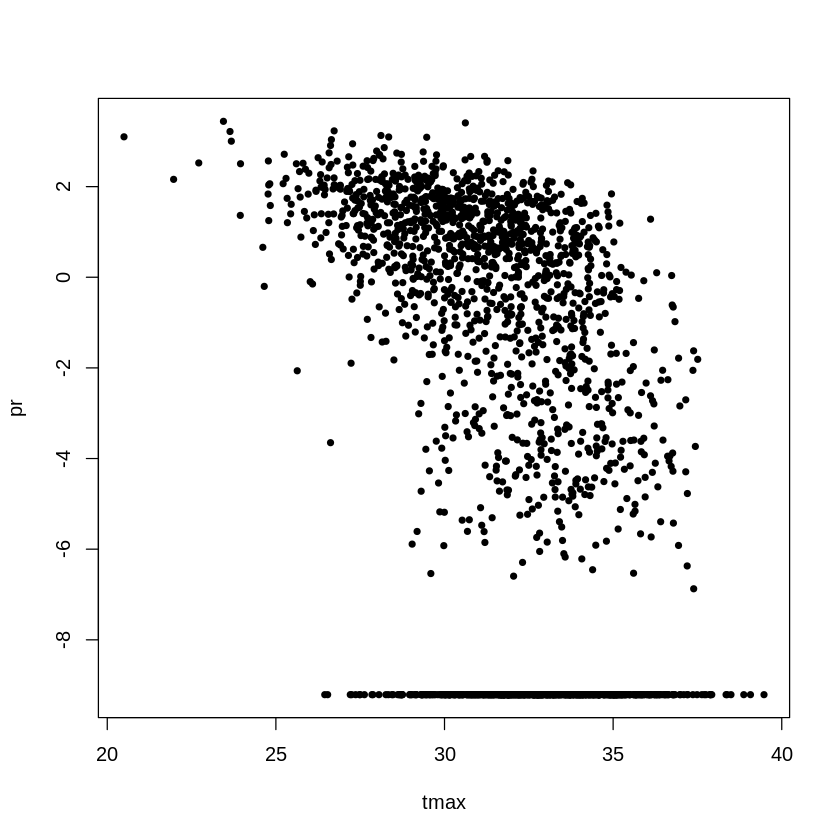

In [6]:
mnth <- weather$month
tmax <- weather$tmax - 273 #convert tmax to celsius
pr <- log(weather$pr + 0.0001) #convert pr to log-scale
plot(tmax,pr,pch=20)

n_total <- length(tmax)
train_ind <- sample(1:n_total,ceiling(0.8*n_total)) #80% training data

tmax_range <- range(tmax)
y1 <- (tmax - tmax_range[1])/diff(tmax_range) # Rescale tmax to [0,1]
X <- cbind(1,pr)

# train and validation data
y1_train <- y1[train_ind]
y1_test <- y1[-train_ind]

# For unconditional density, with only intercept
X1_train <- matrix(X[train_ind,1],ncol = 1)
X1_test <- matrix(X[-train_ind,1],ncol = 1)

# For conditional density of tmax with intercept and log-pr
X2_train <- X[train_ind,1:2]
X2_test <- X[-train_ind,1:2]

# Basis functions, whic are the 'output' from the neural networks
M_basis_train <- t(basis(y1_train,n.knots,knots))
I_basis_train <- t(basis(y1_train,n.knots,knots, integral = TRUE))

M_basis_test <- t(basis(y1_test,n.knots,knots))
I_basis_test <- t(basis(y1_test,n.knots,knots, integral = TRUE))

# Modeling the marginal distribution of `tmax`

Building the model: This follows very similar to the previous examples. We consider a very simple model with one input dimension (the intercept), and output dimensions corresponding to the number of knots. In between there is a single hidden layer with 32 neurons and a `relu` activation function. The output layer has a `softmax` activation function which ensures that the output is 15 probabilities that sum to 1.

Recall the likelihood for SPQR:
$$f(y\vert x) = \sum_{k=1}^K \pi_k(x)M_k(y)$$

In the absence of covariates, it would be:
$$f(y) = \sum_{k=1}^K \pi_kM_k(y)$$

As mentioned before, loss functions in `keras` always has two arguments, `y_true` and `y_pred`. In case of SPQR, `y_true` will be the M-basis functions $M_k(y)$ and `y_pred` would be the neural network output probabilities $\pi_k$.

In [7]:
model <- keras_model_sequential()

model %>%
  # Adds a densely-connected layer with 64 units to the model:
  layer_dense(units = 32, input_shape = c(1), activation = 'sigmoid') %>%

  # Add a final layer with 1 ouput
  layer_dense(units = n.knots, activation = 'softmax')

Compile and print the model architecture

In [8]:
model %>% compile(
  optimizer = "adam",
  loss = nloglik_loss_SPQR
  )
model

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                     │ (None, 32)               │            64 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_1 (Dense)                   │ (None, 20)               │           660 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 724 (2.83 KB)
 Trainable params: 724 (2.83 KB)
 Non-trainable params: 0 (0.00 B)

Note that the response is not `y` but the M-spline basis functions. We follow up by fitting an SPQR model for the marginal distribution of `tmax`. I'm employing early stopping to prevent overfitting, but not checkpointing in this example.

In [9]:
early.stopping <-   callback_early_stopping(monitor = "val_loss", patience = 5)

history <- model %>% fit(
  x = X1_train,
  y = M_basis_train,
  callbacks = list(early.stopping),
  epochs = 100,
  batch_size = 128,
  verbose = 1,
  validation_split = 0.2,
  shuffle = T
)

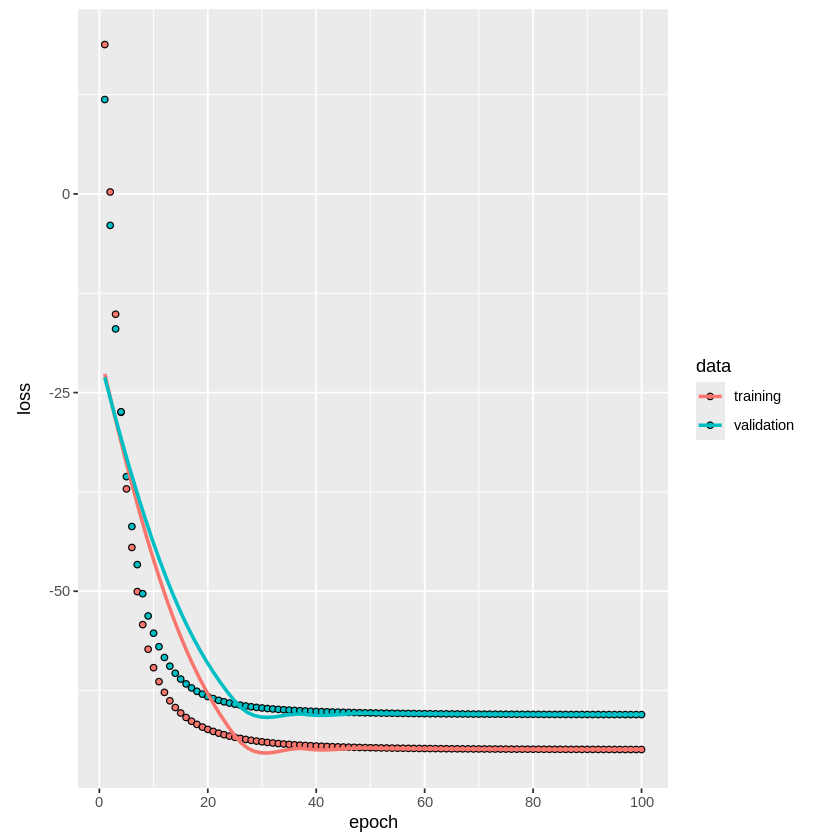

In [10]:
plot(history)

**Diagnostics**: We do a QQ-plot on the validation data, which shows a good fit.

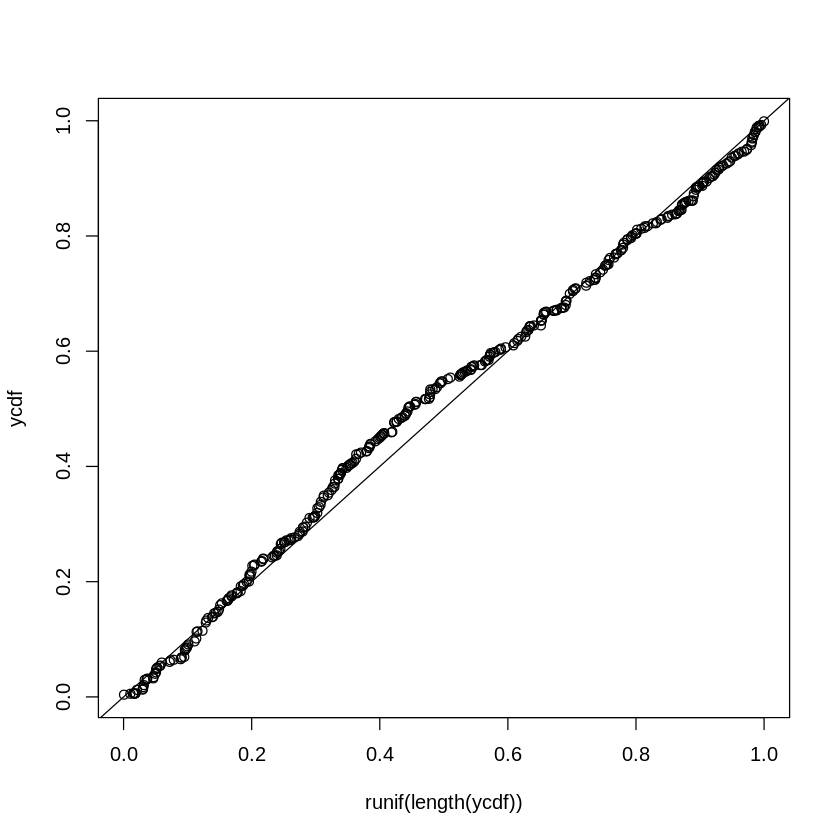

In [11]:
ycdf = predict.SPQR(model,X=X1_test,Y=y1_test,type = 'CDF')
qqplot(runif(length(ycdf)),ycdf)
abline(0,1)

**Predictions**: Since there is only the intercept, we just predict f(y)

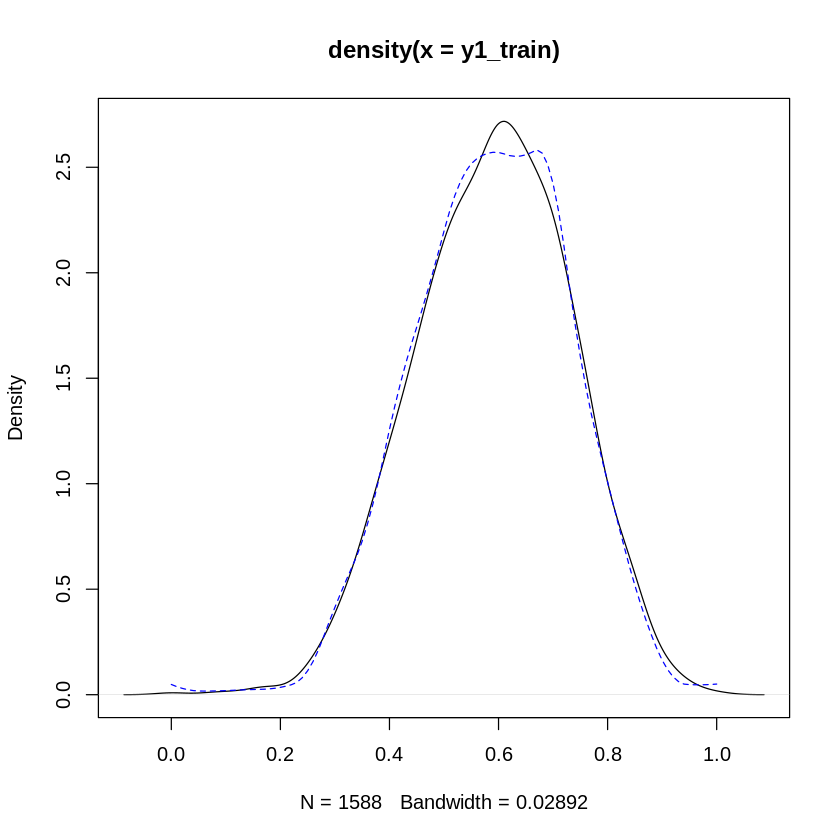

In [12]:
ypred = predict.SPQR(model,X=X1_train,type = 'PDF')
plot(density(y1_train))
lines(seq(0,1,length.out=101),
      ypred[1,],lty=2,col='blue','l')

# Modeling the conditional distribution of `tmax|pr`

**Building the model**: The input to the neural network is now both an intercept term and the precipitation. The methodology is otherwise identical.

In [14]:
model1 <- keras_model_sequential()

model1 %>%
  # Adds a densely-connected layer with 64 units to the model:
  layer_dense(units = 32, input_shape = c(2), activation = 'sigmoid') %>%

  # Add a final layer with 1 ouput
  layer_dense(units = n.knots, activation = 'softmax')

  model1 %>% compile(
  optimizer = "adam",
  loss = nloglik_loss_SPQR
  )
model1

Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                   │ (None, 32)               │            96 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_5 (Dense)                   │ (None, 20)               │           660 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 756 (2.95 KB)
 Trainable params: 756 (2.95 KB)
 Non-trainable params: 0 (0.00 B)

Fit the model:

In [15]:
early.stopping <-   callback_early_stopping(monitor = "val_loss", patience = 5)

history <- model1 %>% fit(
  x = X2_train,
  y = M_basis_train,
  callbacks = list(early.stopping),
  epochs = 100,
  batch_size = 128,
  verbose = 0,
  validation_split = 0.2,
  shuffle = T
)

**Diagnostics**: We do a goodness of fit as before.

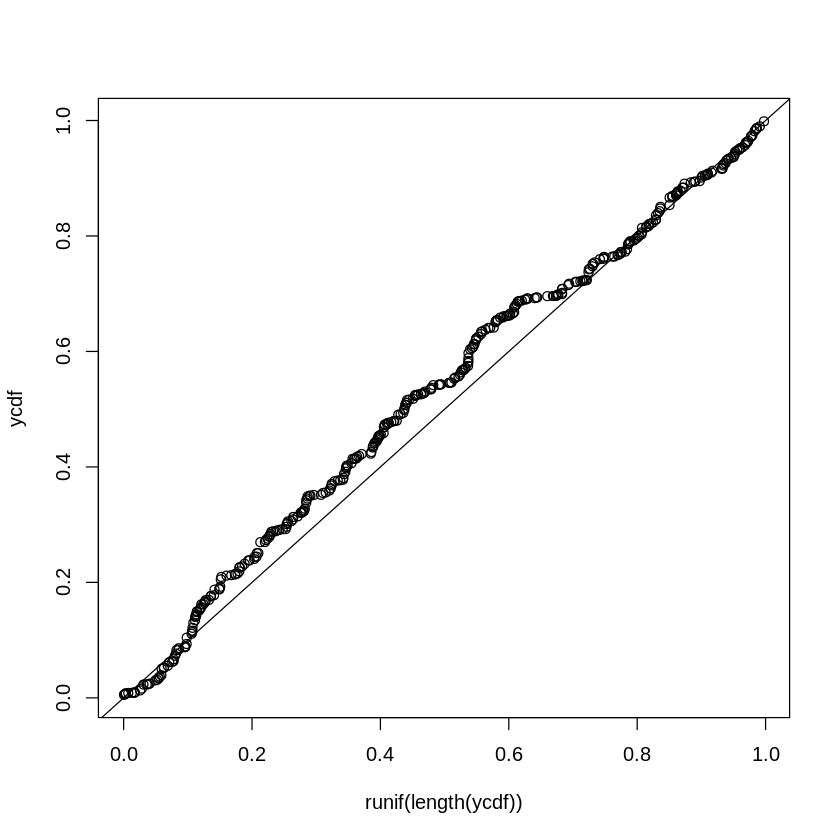

In [16]:
ycdf = predict.SPQR(model1,X=X2_test,Y=y1_test,type = 'CDF')
qqplot(runif(length(ycdf)),ycdf)
abline(0,1)

# Conditional distributions of `tmax|pr`

We plot the conditional distribution of `tmax` for three different precip regimes - no rainfall, 1mm of rainfall, and 6mm of rainfall.

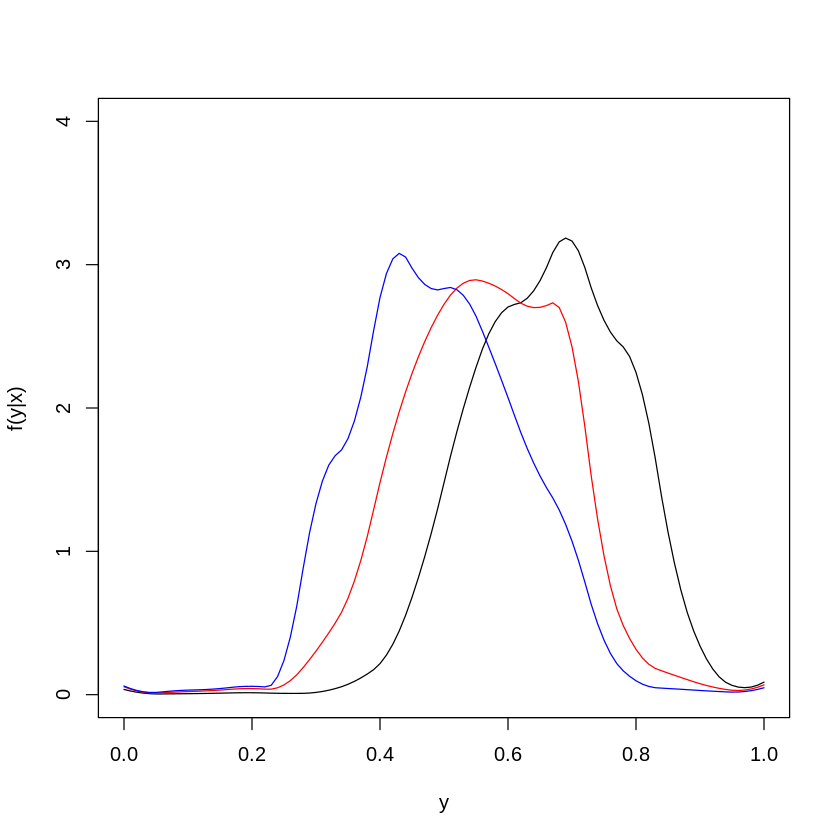

In [17]:
X_pred <- matrix(c(1,log(0.0001),1,log(1),1,log(6)),ncol=2,byrow = T)
ypred = predict.SPQR(model1,X=X_pred,type = 'PDF')

#pr=0mm
plot(c(0:100)/100,ypred[1,],'l',col='black',xlab = 'y',ylab = 'f(y|x)',ylim=c(0,4))

#pr=1mm
lines(c(0:100)/100,ypred[2,],'l',col='red')

#pr=6mm
lines(c(0:100)/100,ypred[3,],'l',col='blue')

# Marginal distribution of `tmax`
To evaluate the marginal density, we sample a range of pr values, and use marginalization to get the unconditional distribution.

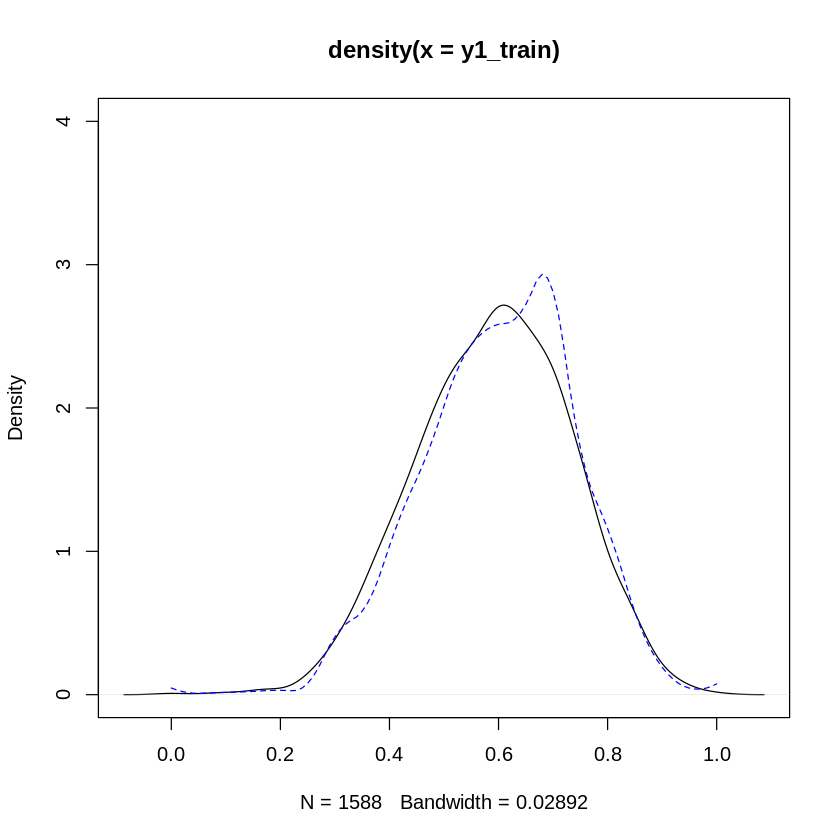

In [18]:
pr_range <- range(pr)
# -9.210340  3.440484

pr_seq <- seq(pr_range[1],pr_range[2],length.out = 1000)
X_pred <- cbind(rep(1,1000),pr_seq)
ypred <- predict.SPQR(model1,X=X_pred,type = 'PDF')
ypred <- apply(ypred,2,mean)
plot(density(y1_train),ylim=c(0,4))
lines(seq(0,1,length.out=101),
      ypred,lty=2,col='blue','l')

# Probability and quantile estimates

The closed form of the CDF means that we can evaluate probability statements associated with the conditional (and marginal) distributions. We can also estimate quantiles.



In [19]:
X_pred <- matrix(c(1,log(0.0001),1,log(1),1,log(6)),ncol=2,byrow = T)

# Median temperature when there is no rainfall
X0 <- matrix(X_pred[1,],nrow = 1)
y0 <- predict.SPQR(model1,X=X0,type = 'QF',tau=0.5)
y0*diff(tmax_range) + tmax_range[1]

# Probability that tmax will be greater than 35 degrees when there is no rainfall
yyy <- (35-tmax_range[1])/diff(tmax_range)
ycdf <- predict.SPQR(model1,X=X0,Y=yyy,type = 'CDF')
1 - ycdf

33.17765


[1] 0.2182021